# Clustering my own Spotify Playlist - *Is my most random playlist... that random?*

This project will analyze my own Spotify music and apply different **Unspervised clustering** techniques to group the songs according to its features (loudness, tempo, danceability, etc). The data was fetched using the **Spotify API & Spotipy module**, the python script i used to connect to Spotify is available in the following link:[spotify_data_extract.py](https://github.com/Mario-UF/DsProyects/blob/main/Spotify_Clustering/spotify_data_extract.py), and is located in the same directory as this notebook.

### Work in progress (WIP)
**WIP:** *For the time being, the project includes K-means clustering technique, in addition to PCA, t-SNE & DBSCAN to do an exploratory analysis and some visualizations.* 

*This project intends to apply more techniques, as Gaussian Mixtures, Hierarchical clustering, Kernel PCA variations, etc. On top of that, it will also include dendrograms and 3D polts to visualize the clusters and hopefully get the best clustering alternative. Finally, we will complete the missing story and the conclusions of each step*

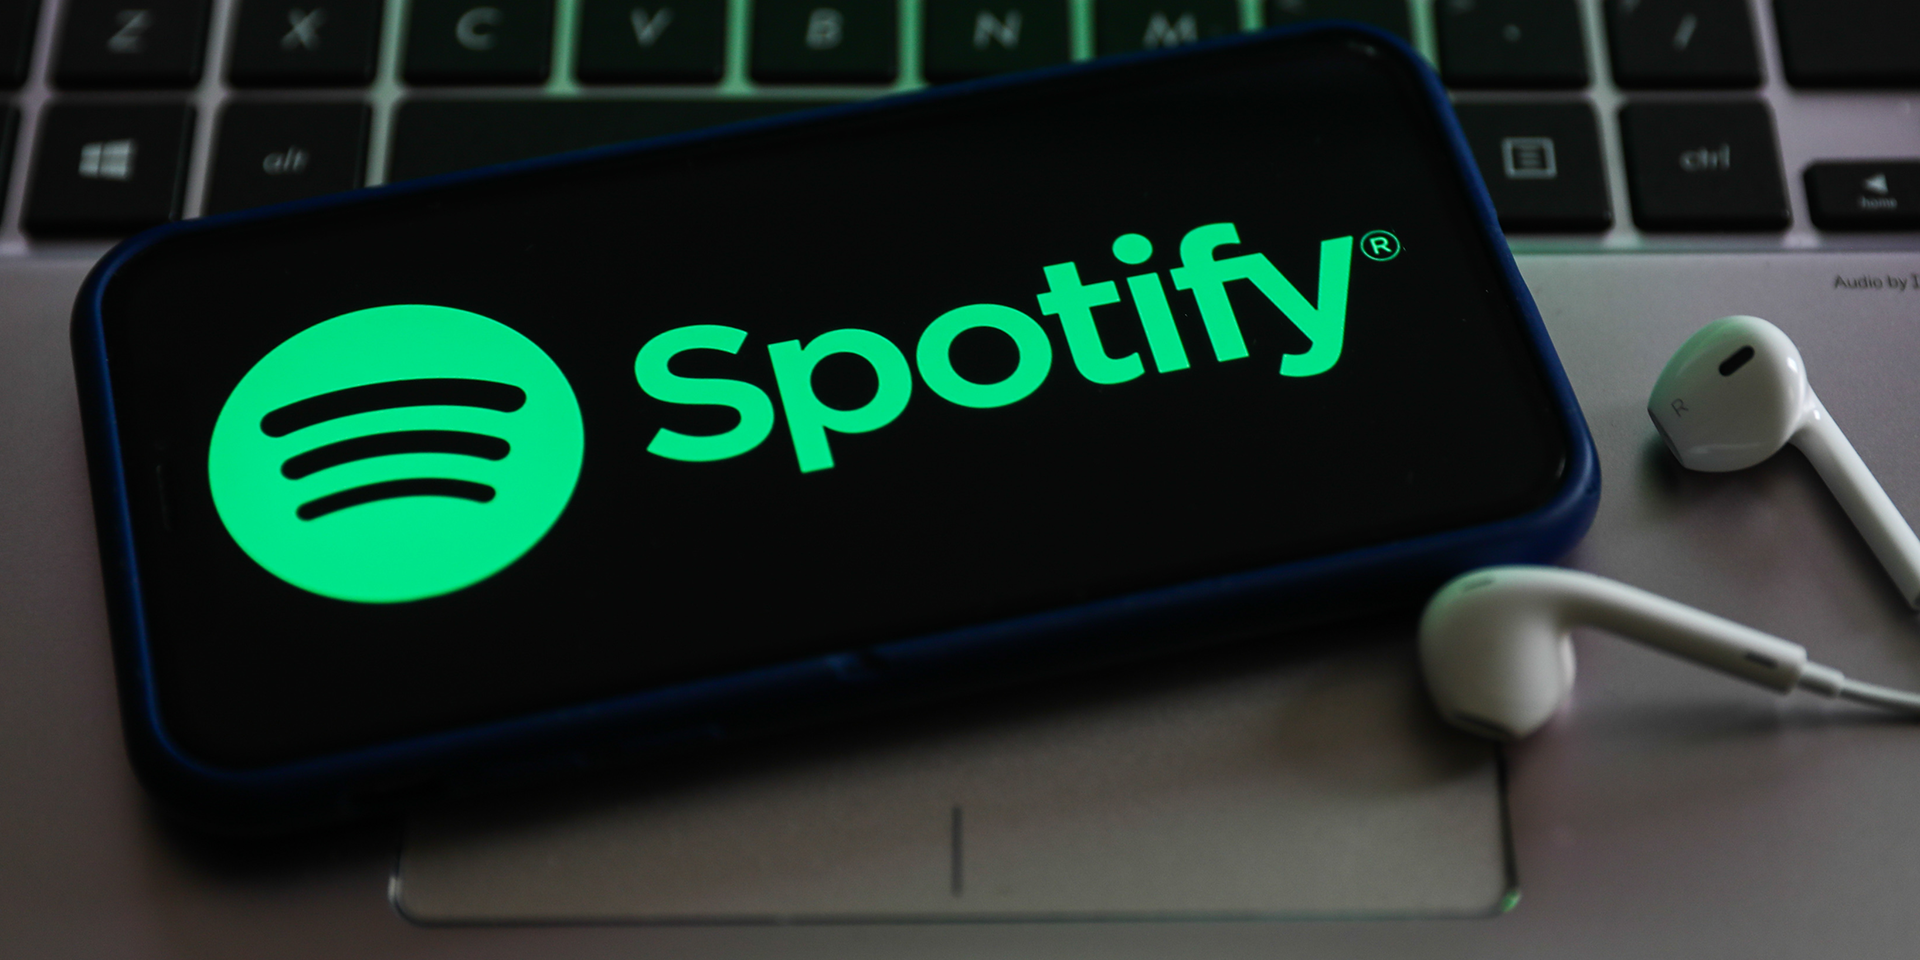

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_colwidth", None)

In [13]:
sns.set_theme(style='darkgrid')

In [14]:
spotify_df = pd.read_csv('myspotifylist.csv').drop('Unnamed: 0',axis=1)
spotify_df.head(2)

name      artist  danceability  \
0                                     No Brainer   DJ Khaled         0.552   
1  Men In Black - From "Men In Black" Soundtrack  Will Smith         0.801   

   energy  loudness  key  mode  speechiness  acousticness  instrumentalness  \
0   0.760    -4.706    0     1       0.3420        0.0733          0.000000   
1   0.581    -8.491    5     0       0.0681        0.0968          0.000318   

   liveness  valence    tempo  duration_ms  time_signature  \
0    0.0865    0.639  135.702       260000               5   
1    0.0971    0.656  107.545       227267               4   

                                    uri  
0  spotify:track:5WvAo7DNuPRmk4APhdPzi8  
1  spotify:track:2FK7fxjzQEXD7Z32HSF0Hl

We will drop the variables we won't use to cluster our songs.

In [15]:
spotify_df = spotify_df.drop(['name', 'artist','uri'],axis=1)
spotify_df.shape

(386, 13)

Since we have different scales among the variables, and mean-centered data is needed to perform PCA (depends on features covariance), we will standardize our features. Standardization prevents the dominance of large features over smaller ones, and centers the data (mean cero).

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
spotify_df = pd.DataFrame(scaler.fit_transform(spotify_df), columns = spotify_df.columns)

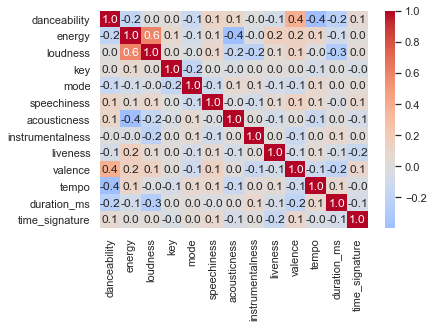

In [17]:
sns.heatmap(spotify_df.corr(), annot=True,fmt='.1f',cmap='coolwarm', center=0);

*A quick scan of the data shows little correlation between the features, with loudness and energy being the most correlated, but with a coefficient of only 0.6*

# 1. Low dimensional visualization

Let's start exploring the data through a low dimensional projection to see if we can grasp any insights from the playlist

## 1.1 PCA (Principal Components Analysis)

PCA is a very usefull technique for dimensionality reduction. This algorithm works by preserving the variance in the dataset and ranking linear combinations of the features (components), which is achived extracting the eigenvectors & eigenvalues from the covariance matrix and redefining the axes as components. 

In this case, to understand how much variance is captured by each Component we can generate a scree plot with the % of variance explained by each Component:

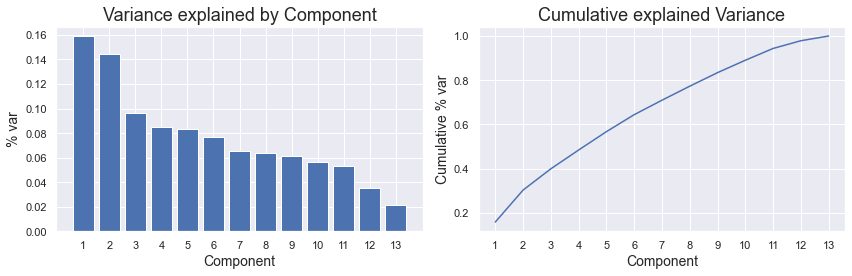

In [18]:
from sklearn.decomposition import PCA

pca = PCA()
pca_data = pca.fit_transform(spotify_df)

f, ax = plt.subplots(1,2,figsize=(12,4))
col_num = len(spotify_df.columns)

ax[0].bar(x=range(1,col_num+1),height=pca.explained_variance_ratio_)
sns.lineplot(x=range(1,col_num+1),y=pca.explained_variance_ratio_.cumsum(),ax=ax[1])
ax[0].set_xticks(range(1,col_num+1))
ax[1].set_xticks(range(1,col_num+1))
ax[0].set_ylabel('% var', fontsize=14)
ax[1].set_ylabel('Cumulative % var', fontsize=14)
ax[0].set_xlabel('Component', fontsize=14)
ax[1].set_xlabel('Component', fontsize=14)
ax[0].set_title('Variance explained by Component', fontsize=18)
ax[1].set_title('Cumulative explained Variance', fontsize=18)
plt.tight_layout();

Now let's take a look at how our list is represented in a 2 dimensional dataset (2 First Components)

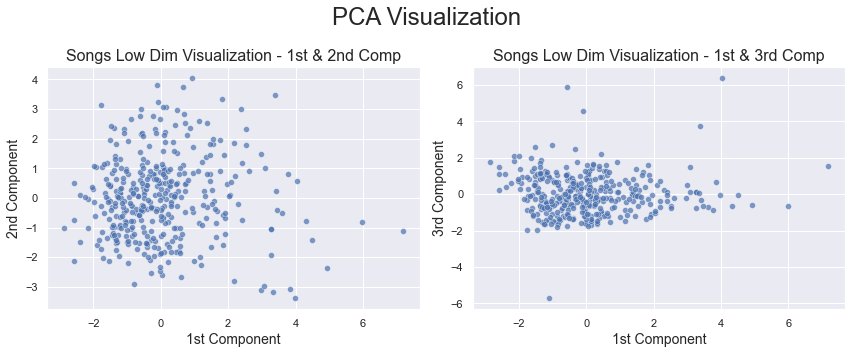

In [19]:
f, ax = plt.subplots(1,2,figsize=(12,5))
f.suptitle('PCA Visualization',fontsize=24)

sns.scatterplot(x=pca_data[:,0],y=pca_data[:,1],alpha=0.7,ax=ax[0])
ax[0].set_xlabel('1st Component',fontsize=14)
ax[0].set_ylabel('2nd Component',fontsize=14)
ax[0].set_title('Songs Low Dim Visualization - 1st & 2nd Comp',fontsize=16)

sns.scatterplot(x=pca_data[:,0],y=pca_data[:,2],alpha=0.7,ax=ax[1])
ax[1].set_xlabel('1st Component',fontsize=14)
ax[1].set_ylabel('3rd Component',fontsize=14)
ax[1].set_title('Songs Low Dim Visualization - 1st & 3rd Comp',fontsize=16)

plt.tight_layout();

It is not easy to distinguish clear shapes of clusters in these spaces, fortunately this is just the beginning!

## 1.2 T-SNE (T-Distributed Stochastic Neighbor Embedding)

This is a very powerful technique to get an idea of how high-dimensional data behave, allowing us to visualize clusters with non-linear boundaries and different intra-cluster variance (standardized using similarity matrices, preserving regional density variations). This is achived by calculating high-dimensional gaussian similarity and translating that to a low-dimensional enviroment, preserving local similarities between observations.

To calculate the high-dimension gaussina similiarity we neet to specify the **Perplexity** parameter, whose values usually varies between 5-50 and has to do with number of neighbors on each cluster. 

Let's try different perplexity numbers (ideally, the values should not be so low to avoid the agglomeration effect due to defining clusters with very small neighborhoods):

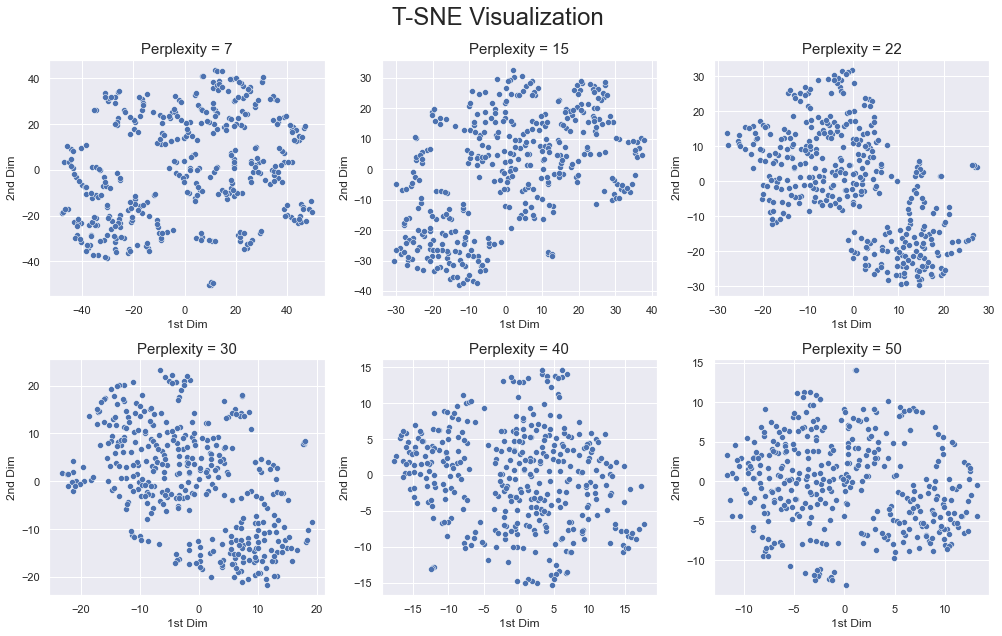

In [20]:
from sklearn.manifold import TSNE

f = plt.figure(figsize=(14,9))
f.suptitle('T-SNE Visualization',fontsize=24)

perpl = [7, 15, 22, 30, 40, 50] 
idx=1
for i in perpl:
    tsne = TSNE(n_components=2, perplexity=i, n_jobs=-1, method='barnes_hut'
            , learning_rate='auto',random_state=123, init='pca').fit_transform(spotify_df)
    ax_new = f.add_subplot(2,3,idx)
    sns.scatterplot(x=tsne[:,0],y=tsne[:,1])
    ax_new.set_title(f'Perplexity = {i}', fontsize=15)
    ax_new.set_xlabel('1st Dim')
    ax_new.set_ylabel('2nd Dim')
    
    idx += 1
    
plt.tight_layout()

Now we can distinguish much more interesting cluster patterns, at least 2 groups or even 3, 4, etc depending on the interpreter

# 2. K-Means Clusters

Now that we have explored how our songs are distributed in a lower dimensional configuration, let's explore an optimal number of clusters using K-means, trying different numbers of clusters. To select the optimal number we have 2 methods:

* Look for a trend change or "Elbow" in the inertia score (mean distance to cluster centroids)
* Pick the highest silhouette score (more precise approach considerng inter and intra cluster distance).

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia_mean_scores = []
silhouette_mean_scores = []
clusters = range(2,15)
for i in clusters:
    kmeans = KMeans(n_clusters=i, random_state=123, n_init=10, init='k-means++').fit(spotify_df)
    inertia_mean_scores.append([i, -kmeans.score(spotify_df)])
    silhouette_mean_scores.append([i, silhouette_score(spotify_df, kmeans.labels_)])
inertia_scores = np.array(inertia_mean_scores)
silhouette_scores = np.array(silhouette_mean_scores)

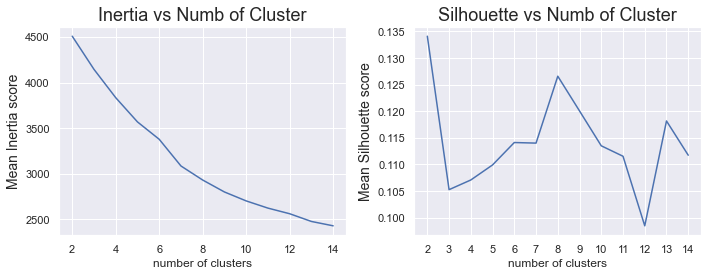

In [22]:
f, ax = plt.subplots(1,2,figsize=(10,4))

sns.lineplot(x=inertia_scores[:,0],y=inertia_scores[:,1],ax=ax[0])
sns.lineplot(x=silhouette_scores[:,0],y=silhouette_scores[:,1],ax=ax[1])
ax[0].set_xlabel('number of clusters')
ax[1].set_xlabel('number of clusters')
ax[0].set_ylabel('Mean Inertia score', fontsize=14)
ax[1].set_ylabel('Mean Silhouette score', fontsize=14)
ax[0].set_title('Inertia vs Numb of Cluster', fontsize=18)
ax[1].set_title('Silhouette vs Numb of Cluster', fontsize=18)
plt.xticks(clusters)
plt.tight_layout();

* Since we can't distinguish any major trend change ("elbow") by visual inspection of the inertia, we rely on Silhouette score approach. In this case, the best result is obtained with 2 clusters, followed by an 8-cluster configuration.


* Silhouette score has a range of [-1,+1], being +1 the best outcome, indicating that the observation is far form other clusters, a coef close to 0 indicates the observation is close to the decision boundary separing the clusters, and -1 indicates that the observation may have been assigned to the wrong cluster.


* **Looking at the mean silhouette score plot, we can see a low score, around 0.13 in the best case scenario, and thus a bad clustering performance.**

Let's inspect how the Silhouettes behave inside the 2-cluster & 8-cluster scenario:

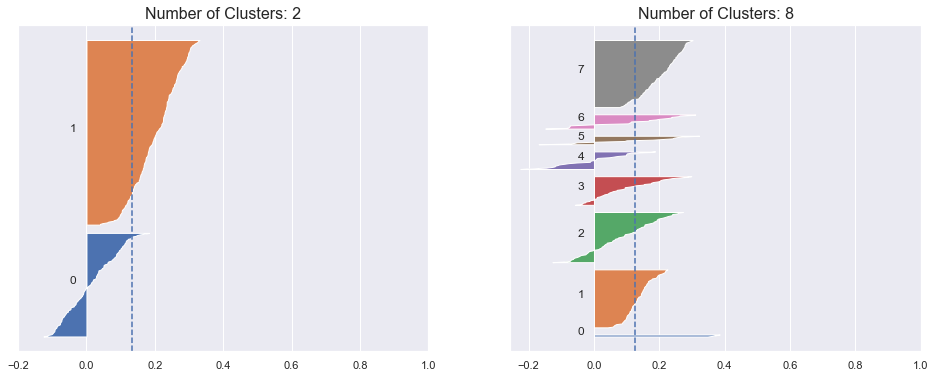

In [23]:
from sklearn.metrics import silhouette_samples

f = plt.figure(figsize=(25,6))

idx=1
clusters = [2,8]

for i in clusters:
    ax = f.add_subplot(1,3,idx)
    kmeans = KMeans(n_clusters=i, random_state=123, n_init=10, init='k-means++').fit(spotify_df)
    silh_mean_score = silhouette_score(spotify_df, kmeans.labels_)
    obs_silhouettes = silhouette_samples(spotify_df, kmeans.labels_)
    
    y_lower = 10
    for c in range(i):
        ith_cluster_obs_silhouettes = obs_silhouettes[kmeans.labels_==c]
        ith_cluster_obs_silhouettes.sort()
        
        y_upper = y_lower + len(ith_cluster_obs_silhouettes)
        ax.fill_betweenx(np.arange(y_lower, y_upper)
                        ,x1=0   # fill btwn 0 and x2
                        ,x2=ith_cluster_obs_silhouettes)
        
        ax.text(-0.05, y_lower + 0.5 * len(ith_cluster_obs_silhouettes), str(c))
        
        y_lower = 10 + y_upper
    
    ax.set_yticks([])
    ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_title(f'Number of Clusters: {i}', fontsize=16)
    ax.axvline(x=silh_mean_score, color="b", linestyle="--")
    idx +=1

In both scenarios, the observed silhouettes scores are not so good and have room for improvement. This improvement can be achived by trying nonlinear kernel methods, performing feature selection, removing outliers, applying other techniques such as Gaussian Mixtures, etc.

In the mean time, let's visually inspect the 2 scenarios (2 and 8 clusters) on our low-dimensional space:

In [24]:
kmeans2 = KMeans(n_init=10, random_state=123, n_clusters=2).fit(spotify_df)
kmeans8 = KMeans(n_init=10, random_state=123, n_clusters=8).fit(spotify_df)

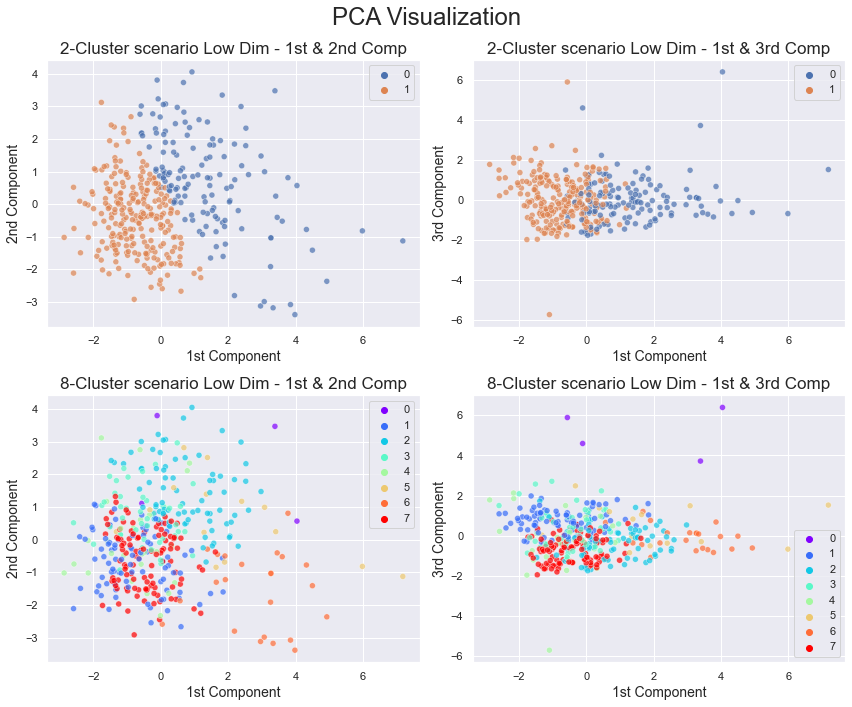

In [25]:
f, ax = plt.subplots(2,2,figsize=(12,10))
f.suptitle('PCA Visualization',fontsize=24)

sns.scatterplot(x=pca_data[:,0],y=pca_data[:,1],alpha=0.7,ax=ax[0,0], hue=kmeans2.labels_)
ax[0,0].set_xlabel('1st Component',fontsize=14)
ax[0,0].set_ylabel('2nd Component',fontsize=14)
ax[0,0].set_title('2-Cluster scenario Low Dim - 1st & 2nd Comp',fontsize=17)

sns.scatterplot(x=pca_data[:,0],y=pca_data[:,2],alpha=0.7,ax=ax[0,1], hue=kmeans2.labels_)
ax[0,1].set_xlabel('1st Component',fontsize=14)
ax[0,1].set_ylabel('3rd Component',fontsize=14)
ax[0,1].set_title('2-Cluster scenario Low Dim - 1st & 3rd Comp',fontsize=17)

sns.scatterplot(x=pca_data[:,0],y=pca_data[:,1],alpha=0.7,ax=ax[1,0], hue=kmeans8.labels_, palette='rainbow', legend='full')
ax[1,0].set_xlabel('1st Component',fontsize=14)
ax[1,0].set_ylabel('2nd Component',fontsize=14)
ax[1,0].set_title('8-Cluster scenario Low Dim - 1st & 2nd Comp',fontsize=17)

sns.scatterplot(x=pca_data[:,0],y=pca_data[:,2],alpha=0.7,ax=ax[1,1], hue=kmeans8.labels_, palette='rainbow', legend='full')
ax[1,1].set_xlabel('1st Component',fontsize=14)
ax[1,1].set_ylabel('3rd Component',fontsize=14)
ax[1,1].set_title('8-Cluster scenario Low Dim - 1st & 3rd Comp',fontsize=17)

plt.tight_layout();

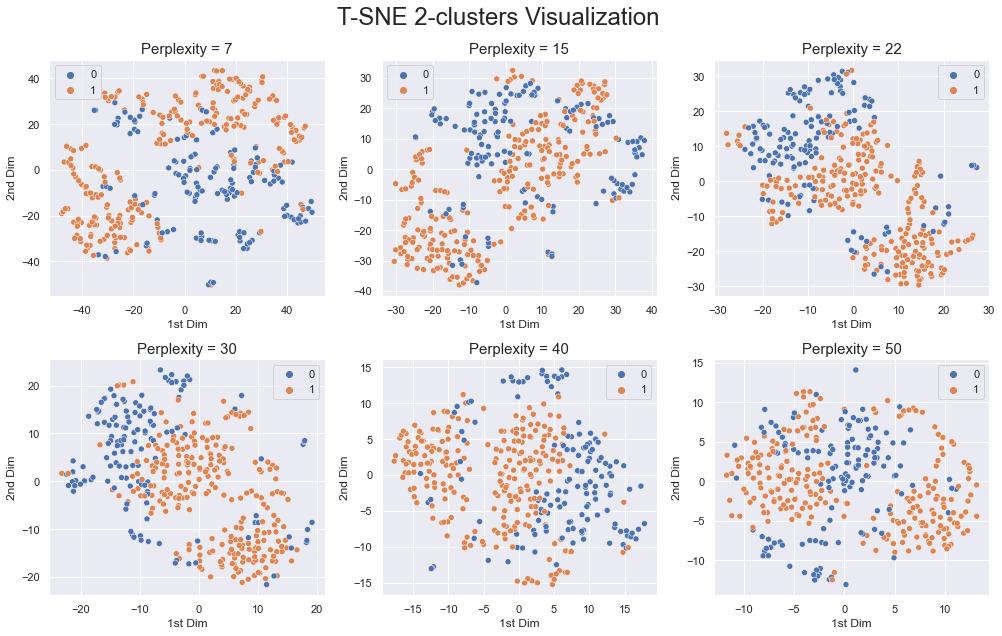

In [26]:
f = plt.figure(figsize=(14,9))
f.suptitle('T-SNE 2-clusters Visualization',fontsize=24)

perpl = [7, 15, 22, 30, 40, 50] 
idx=1
for i in perpl:
    tsne = TSNE(n_components=2, perplexity=i, n_jobs=-1, method='barnes_hut'
            , learning_rate='auto',random_state=123, init='pca').fit_transform(spotify_df)
    ax_new = f.add_subplot(2,3,idx)
    sns.scatterplot(x=tsne[:,0],y=tsne[:,1], hue=kmeans2.labels_)
    ax_new.set_title(f'Perplexity = {i}', fontsize=15)
    ax_new.set_xlabel('1st Dim')
    ax_new.set_ylabel('2nd Dim')
    
    idx += 1
    
plt.tight_layout()

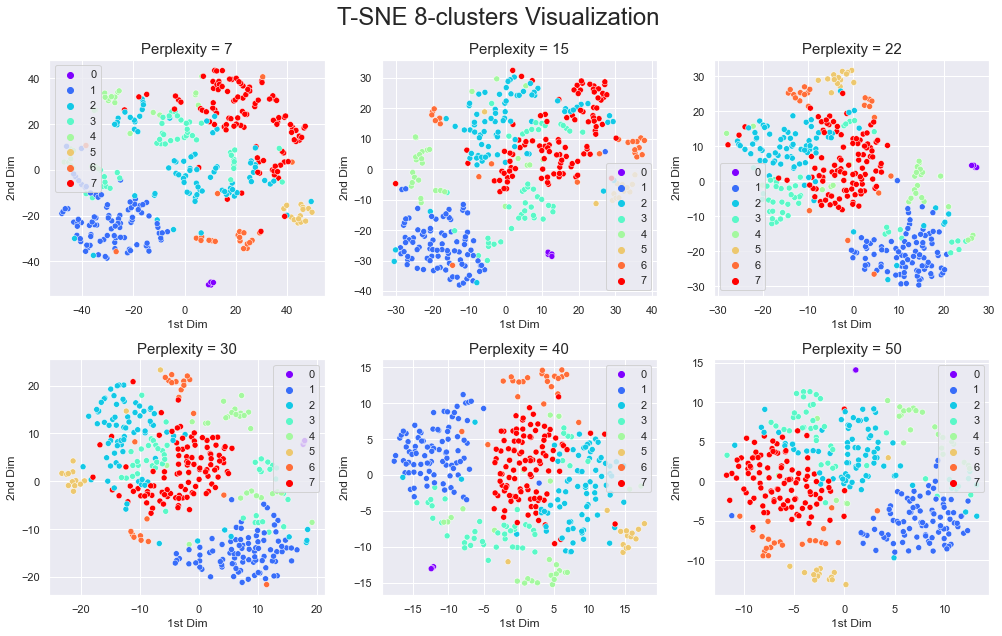

In [27]:
f = plt.figure(figsize=(14,9))
f.suptitle('T-SNE 8-clusters Visualization',fontsize=24)

perpl = [7, 15, 22, 30, 40, 50] 
idx=1
for i in perpl:
    tsne = TSNE(n_components=2, perplexity=i, n_jobs=-1, method='barnes_hut'
            , learning_rate='auto',random_state=123, init='pca').fit_transform(spotify_df)
    ax_new = f.add_subplot(2,3,idx)
    sns.scatterplot(x=tsne[:,0],y=tsne[:,1], hue=kmeans8.labels_,palette='rainbow', legend='full')
    ax_new.set_title(f'Perplexity = {i}', fontsize=15)
    ax_new.set_xlabel('1st Dim')
    ax_new.set_ylabel('2nd Dim')
    
    idx += 1
    
plt.tight_layout()

Let's explore more alternatives to improve our results!

# 3. Feature selection - Work in Progress

In the previous section we noted the tere is room for improvement, and feature selection plays a very important role in this. Clustering techniques are based on calculation of distances, which implies that having higher dimensionality can inflate our inertia or any distance metric, and as the dimensions increase, the distances will increasingly converge to constant values. In addition to that, when the feature is not relevant to clustering, it adds noise and makes it difficult the process of assign the observations properly.

# 4. DBSCAN (Density-Based Spatial Clustering)

### Outlier detection using DBSCAN

* Outliers can drag the centroids, so it may be interesting analyse an scenario without them...

The green dots (label equal to -1) represents the outliers depending on the distance (eps) passed to DBSCAN algorithm

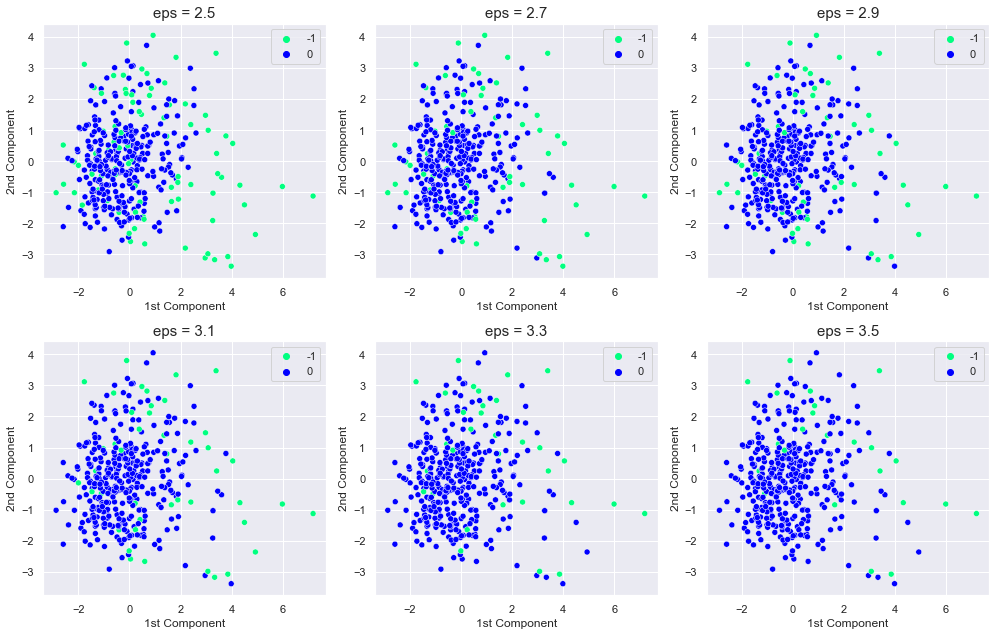

In [28]:
from sklearn.cluster import DBSCAN

f = plt.figure(figsize=(14, 9))

idx=1
for i in np.linspace(2.5,3.5,6):
    db = DBSCAN(eps=i, min_samples=5).fit_predict(spotify_df)
    ax_new = f.add_subplot(2, 3, idx)
    sns.scatterplot(x=pca_data[:,0],y=pca_data[:,1], hue=db,palette='winter_r')
    ax_new.set_title(f'eps = {i}', fontsize=15)
    ax_new.set_xlabel('1st Component')
    ax_new.set_ylabel('2nd Component')
    
    idx += 1

plt.tight_layout()

## Work in Progress...

# X. Understanding our Clusters - Work in Progress

## X.1 PCA linear decomposition

## X.2 SHAP (Shapley Additive Explanations)

# Y. Hierarchical Clustering

# Z. Spectral Clustering

# W. Kernel PCA

# V. Gaussian Mixtures

# V.1 Bayesian Gaussian Mixtures